# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [5]:
st = time.time()
df = pd.read_csv('./new_feature_by_kageyama_feature_matrix_noIDs_delmissing_delunimportant.csv')
time.time() - st

59.40703582763672

In [6]:
df = df.drop('SK_ID_CURR', axis=1)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


43

In [8]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758136	valid_1's auc: 0.751718
[200]	training's auc: 0.780409	valid_1's auc: 0.765087
[300]	training's auc: 0.797896	valid_1's auc: 0.774478
[400]	training's auc: 0.8097	valid_1's auc: 0.780059
[500]	training's auc: 0.818857	valid_1's auc: 0.782091
[600]	training's auc: 0.826772	valid_1's auc: 0.784411
[700]	training's auc: 0.834132	valid_1's auc: 0.785475
[800]	training's auc: 0.840515	valid_1's auc: 0.78644
[900]	training's auc: 0.846422	valid_1's auc: 0.787401
[1000]	training's auc: 0.852209	valid_1's auc: 0.78785
[1100]	training's auc: 0.857534	valid_1's auc: 0.788544
[1200]	training's auc: 0.862507	valid_1's auc: 0.788832
Early stopping, best iteration is:
[1179]	training's auc: 0.861488	valid_1's auc: 0.789075
Fold  1 AUC : 0.789075
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758224	valid_1's auc: 0.74819
[200]	training's auc: 0.780359	valid_1's auc: 0

[1000]	training's auc: 0.851856	valid_1's auc: 0.786441
[1100]	training's auc: 0.857297	valid_1's auc: 0.787064
[1200]	training's auc: 0.862234	valid_1's auc: 0.787595
[1300]	training's auc: 0.867072	valid_1's auc: 0.787731
[1400]	training's auc: 0.87177	valid_1's auc: 0.787979
[1500]	training's auc: 0.876117	valid_1's auc: 0.78807
[1600]	training's auc: 0.880277	valid_1's auc: 0.7886
[1700]	training's auc: 0.884392	valid_1's auc: 0.788795
[1800]	training's auc: 0.888284	valid_1's auc: 0.78891
Early stopping, best iteration is:
[1740]	training's auc: 0.885884	valid_1's auc: 0.78904
Fold  8 AUC : 0.789040
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758196	valid_1's auc: 0.745253
[200]	training's auc: 0.780422	valid_1's auc: 0.758648
[300]	training's auc: 0.797788	valid_1's auc: 0.768627
[400]	training's auc: 0.809411	valid_1's auc: 0.774276
[500]	training's auc: 0.818771	valid_1's auc: 0.777188
[600]	training's auc: 0.826777	valid_1's auc: 0.77

[100]	training's auc: 0.75775	valid_1's auc: 0.74739
[200]	training's auc: 0.779911	valid_1's auc: 0.765668
[300]	training's auc: 0.79747	valid_1's auc: 0.778401
[400]	training's auc: 0.808975	valid_1's auc: 0.784048
[500]	training's auc: 0.818501	valid_1's auc: 0.787561
[600]	training's auc: 0.826553	valid_1's auc: 0.790135
[700]	training's auc: 0.833712	valid_1's auc: 0.79145
[800]	training's auc: 0.840407	valid_1's auc: 0.792614
[900]	training's auc: 0.846436	valid_1's auc: 0.793216
[1000]	training's auc: 0.852005	valid_1's auc: 0.793954
[1100]	training's auc: 0.857243	valid_1's auc: 0.794405
[1200]	training's auc: 0.862319	valid_1's auc: 0.794583
[1300]	training's auc: 0.867123	valid_1's auc: 0.794613
[1400]	training's auc: 0.871756	valid_1's auc: 0.795033
[1500]	training's auc: 0.876179	valid_1's auc: 0.795239
[1600]	training's auc: 0.880345	valid_1's auc: 0.795609
[1700]	training's auc: 0.884343	valid_1's auc: 0.795526
Early stopping, best iteration is:
[1605]	training's auc: 0.8

[800]	training's auc: 0.840621	valid_1's auc: 0.787423
[900]	training's auc: 0.846647	valid_1's auc: 0.788291
[1000]	training's auc: 0.852315	valid_1's auc: 0.788695
[1100]	training's auc: 0.857706	valid_1's auc: 0.789485
[1200]	training's auc: 0.862586	valid_1's auc: 0.789728
[1300]	training's auc: 0.867368	valid_1's auc: 0.789872
[1400]	training's auc: 0.871635	valid_1's auc: 0.789923
[1500]	training's auc: 0.876226	valid_1's auc: 0.790147
[1600]	training's auc: 0.88056	valid_1's auc: 0.790736
[1700]	training's auc: 0.88471	valid_1's auc: 0.790785
[1800]	training's auc: 0.888335	valid_1's auc: 0.790536
Early stopping, best iteration is:
[1725]	training's auc: 0.885636	valid_1's auc: 0.790846
Fold 24 AUC : 0.790846
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758382	valid_1's auc: 0.746742
[200]	training's auc: 0.779985	valid_1's auc: 0.765699
[300]	training's auc: 0.797292	valid_1's auc: 0.778905
[400]	training's auc: 0.809026	valid_1's auc: 

In [9]:
sub.to_csv('./kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant.csv', index=None)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


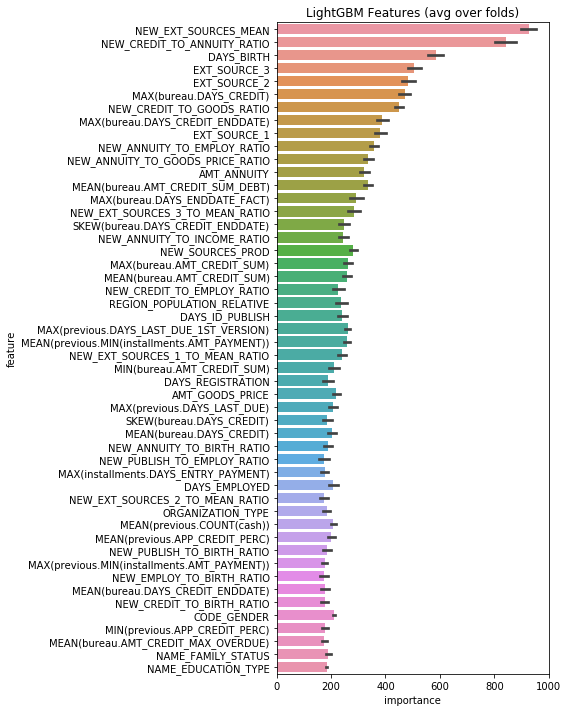

In [11]:
display_importances(feature_importance_df)

In [12]:
time.time() - st

12971.157368898392